## Вариант 2

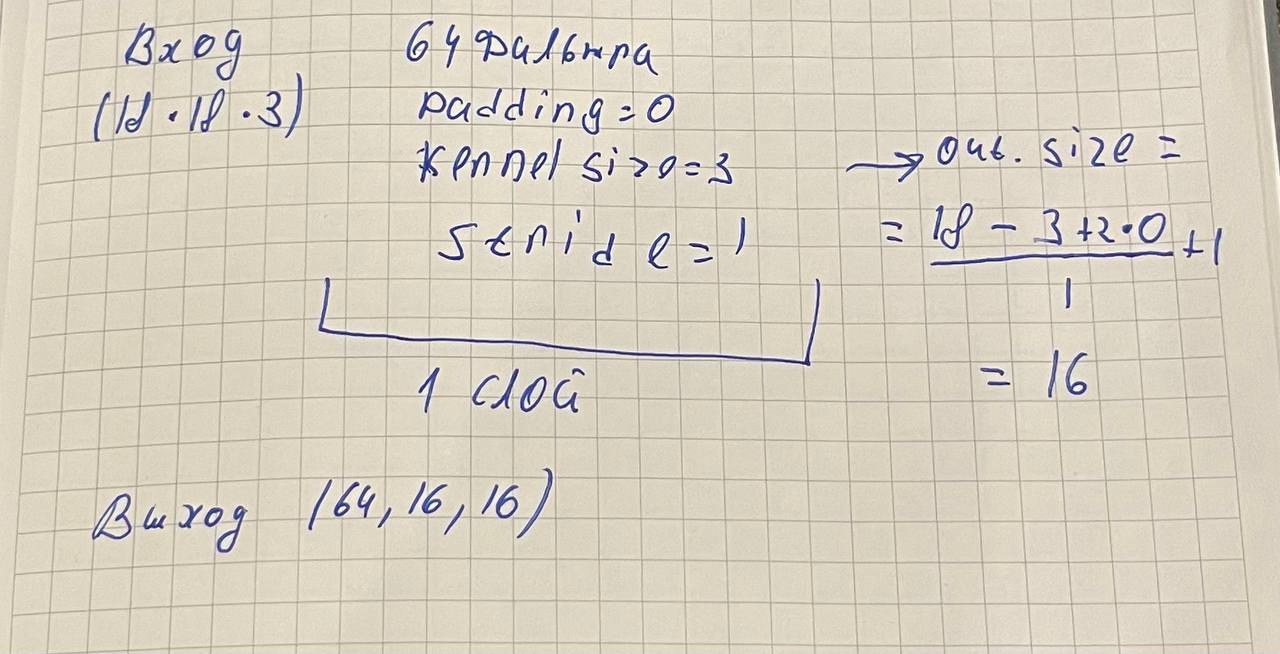

При padding = 1 на выходе будет (18 * 18 * 64). То есть размер будет больше, так как padding = 0 обрезал края 

Среднее значение активации, по идее, может быть меньше, так как по краям будут нули

In [41]:
import torch
from torch import nn

class ConvPadding0(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Conv2d(
            in_channels=3, 
            out_channels=64, 
            kernel_size=3, 
            stride=1, 
            padding=0      
        )
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.conv(x)
        x = self.relu(x)
        return x


# тест
model_p0 = ConvPadding0()

In [ ]:
class ConvPadding1(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Conv2d(
            in_channels=3, 
            out_channels=64, 
            kernel_size=3, 
            stride=1, 
            padding=1      
        )
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.conv(x)
        x = self.relu(x)
        return x


# тест
model_p1 = ConvPadding1()



Output (padding=1): torch.Size([1, 64, 18, 18])


In [ ]:
test_image = torch.randn(1, 3, 18, 18)  

In [43]:
out1 = model_p0(test_image)
print("Output (padding=0):", out1.shape)
print("Mean activation:", out1.mean().item())

Output (padding=0): torch.Size([1, 64, 16, 16])
Mean activation: 0.23403970897197723


In [44]:
out2 = model_p1(test_image)
print("Output (padding=1):", out2.shape)
print("Mean activation:", out2.mean().item())

Output (padding=1): torch.Size([1, 64, 18, 18])
Mean activation: 0.22864164412021637


## Вариант 4

In [2]:
import torch
from torch import nn
import torch.nn.functional as F

class ConvNet_Flatten(nn.Module):
    def __init__(self):
        super().__init__()
        # Блок свёрток: получаем (B, 128, 8, 8)
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)    # -> (32, 32, 32)
        self.pool  = nn.MaxPool2d(2, 2)                            # 32x32 -> 16x16
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)   # -> (64, 16, 16)
        # второй pool даст 8x8
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)  # -> (128, 8, 8)

        self.relu = nn.ReLU()

        # Классификатор по примеру: Flatten -> FC(8192->128) -> FC(128->10)
        self.fc1 = nn.Linear(128 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        # 1-й свёрточный блок
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)                 # (B, 32, 16, 16)

        # 2-й свёрточный блок
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool(x)                 # (B, 64, 8, 8)

        # 3-й свёрточный слой (без дополнительного pool, чтобы остаться на 8x8)
        x = self.conv3(x)
        x = self.relu(x)                 # (B, 128, 8, 8)

        # Flatten → Linear
        x = x.view(x.size(0), -1)        # (B, 128*8*8)
        x = F.relu(self.fc1(x))          # (B, 128)
        x = self.fc2(x)                  # (B, 10) — логиты
        return x

model = ConvNet_Flatten()

test_tensor = torch.randn(1, 3, 32 ,32)

model(test_tensor)


tensor([[-0.0058, -0.0146, -0.0179, -0.0610, -0.0165,  0.0290,  0.0804, -0.0188,
          0.1919, -0.1230]], grad_fn=<AddmmBackward0>)

In [7]:
from torch.optim import Adam
from torchvision import datasets, transforms
from tqdm import tqdm

# данные
transform = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset = datasets.CIFAR10('./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)

# модель
model = ConvNet_Flatten()

# обучение
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0.001)

epochs = 5
train_losses = []

for epoch in range(epochs):
    model.train()
    
    for images, labels in tqdm(train_loader):
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        train_losses.append(loss.item())
        loss.backward()
        optimizer.step()

    # === вычисляем дисперсию скрытых активаций после fc1 ===
    model.eval()
    with torch.no_grad():
        sample_imgs, _ = next(iter(train_loader))  # один батч
        x = model.conv1(sample_imgs)
        x = model.relu(x)
        x = model.pool(x)

        x = model.conv2(x)
        x = model.relu(x)
        x = model.pool(x)

        x = model.conv3(x)
        x = model.relu(x)

        x = x.view(x.size(0), -1)
        feats = F.relu(model.fc1(x))  # <-- перед final layer (fc2)

        var = feats.var(dim=0, unbiased=False).mean().item()

    print(f"Epoch [{epoch+1}/{epochs}], Loss: {sum(train_losses)/len(train_losses):.4f}")
    print(f"Дисперсия активаций перед финальным слоем: {var:.6f}")


100%|██████████| 782/782 [00:25<00:00, 31.07it/s]


Epoch [1/5], Loss: 1.4755
Дисперсия активаций перед финальным слоем: 1.504419


100%|██████████| 782/782 [00:25<00:00, 30.60it/s]


Epoch [2/5], Loss: 1.2791
Дисперсия активаций перед финальным слоем: 1.427396


100%|██████████| 782/782 [00:25<00:00, 30.10it/s]


Epoch [3/5], Loss: 1.1534
Дисперсия активаций перед финальным слоем: 1.656393


100%|██████████| 782/782 [00:25<00:00, 31.07it/s]


Epoch [4/5], Loss: 1.0584
Дисперсия активаций перед финальным слоем: 1.984128


100%|██████████| 782/782 [00:24<00:00, 31.55it/s]

Epoch [5/5], Loss: 0.9823
Дисперсия активаций перед финальным слоем: 1.913304


In [ ]:
import torch
from torch import nn
import torch.nn.functional as F

class ConvNet_GAP(nn.Module):
    def __init__(self):
        super().__init__()
        # 3 свёртки до (B, 128, 8, 8)
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)     # -> (32, 32, 32)
        self.pool  = nn.MaxPool2d(2, 2)                             # 32x32 -> 16x16
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)    # -> (64, 16, 16)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)   # -> (128, 8, 8)

        self.relu = nn.ReLU()

        # Вместо FC(8192→128→10), как в Flatten,
        # здесь только 128 → 10 (после GAP)
        self.fc = nn.Linear(128, 10)

    def forward(self, x):
        # 1-й свёрточный блок
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)                  # (B, 32, 16, 16)

        # 2-й свёрточный блок
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool(x)                  # (B, 64, 8, 8)

        # 3-я свёртка (оставляем 8×8)
        x = self.conv3(x)
        x = self.relu(x)                  # (B, 128, 8, 8)

        # Global Average Pooling → (B, 128, 1, 1)
        x = F.adaptive_avg_pool2d(x, 1)

        # (B, 128)
        x = x.view(x.size(0), -1)

        # Linear → (B, 10)
        x = self.fc(x)
        return x

Выход: torch.Size([1, 10])


In [8]:
from torch.optim import Adam
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from tqdm import tqdm

# данные как в примере
transform = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset = datasets.CIFAR10('./data', train=True, download=True, transform=transform)
train_loader  = DataLoader(train_dataset, batch_size=64, shuffle=True)

model = ConvNet_GAP()

criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0.001)

epochs = 5
train_losses = []

for epoch in range(epochs):
    model.train()
    for images, labels in tqdm(train_loader):
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        train_losses.append(loss.item())
        loss.backward()
        optimizer.step()

    # дисперсия активаций ПЕРЕД финальным слоем (после GAP)
    model.eval()
    with torch.no_grad():
        sample_imgs, _ = next(iter(train_loader))
        x = model.conv1(sample_imgs); x = model.relu(x); x = model.pool(x)
        x = model.conv2(x);          x = model.relu(x); x = model.pool(x)
        x = model.conv3(x);          x = model.relu(x)
        x = F.adaptive_avg_pool2d(x, 1)  # (B, 128, 1, 1)
        feats = x.view(x.size(0), -1)    # (B, 128) — перед self.fc
        var_mean = feats.var(dim=0, unbiased=False).mean().item()

    print(f'Epoch [{epoch+1}/{epochs}], Loss: {sum(train_losses)/len(train_losses):.4f}')
    print(f'Дисперсия активаций перед финальным слоем (GAP): {var_mean:.6f}')


100%|██████████| 782/782 [00:23<00:00, 32.60it/s]


Epoch [1/5], Loss: 1.8296
Дисперсия активаций перед финальным слоем (GAP): 0.226982


100%|██████████| 782/782 [00:23<00:00, 32.93it/s]


Epoch [2/5], Loss: 1.7062
Дисперсия активаций перед финальным слоем (GAP): 0.202542


100%|██████████| 782/782 [00:23<00:00, 33.04it/s]


Epoch [3/5], Loss: 1.6195
Дисперсия активаций перед финальным слоем (GAP): 0.333444


100%|██████████| 782/782 [00:23<00:00, 32.96it/s]


Epoch [4/5], Loss: 1.5506
Дисперсия активаций перед финальным слоем (GAP): 0.333515


100%|██████████| 782/782 [00:23<00:00, 32.96it/s]

Epoch [5/5], Loss: 1.4939
Дисперсия активаций перед финальным слоем (GAP): 0.385479


Flatten - высокодисперсный подход. Видно, что loss быстрее снижается, то есть хорошо подстраивается под тренировочные данные = выше риск переобучения

GAP более стабилен. меньше разброс — учится медленнее на трейне, но лучше обобщает